## <font color='coral'>**Appel de l'environment** </font>

In [2]:
%reset -f
import ipywidgets as widgets
%matplotlib widget

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from IPython.display import clear_output
from RVutils import *
from scipy import special
import scipy.integrate as integrate
from scipy.misc import derivative

## For sliders
from ipywidgets import Layout, interact

## Set up rc
plt.rcParams['image.cmap'] = 'RdYlBu_r'
plt.rcParams['axes.formatter.limits'] = (-3,1)
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams.update({"axes.grid" : True})
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.markeredgewidth'] = 2.0
plt.rc('font',size=18)
me = (0.1,0.1) #Markevery

## <font color='coral'>**Chargement des données** </font>

In [2]:
data = np.loadtxt('data_exp/exp_profs_45333.dat')
data_q = np.loadtxt('data_exp/exp_profs_q_45333.dat')

data_exp = np.vstack((data,data_q))

param = ['rho','nustar_lowq','nustar_highq','eps','delta','q_lowq','q_highq']
data_dic  = {}
for ip,p in enumerate(param):
    data_dic[p] = data_exp[ip,:]

## <font color='coral'>**Defining collisional functions** </font>

In [20]:
# %% Collisions related functions
def Phi_v(v)   : return (2/(np.sqrt(np.pi))) * integrate.quad(lambda x: np.exp(-x**2),0,v)[0]
def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))
def nu_bar_v(v): return 0.75*np.sqrt(2*np.pi) * v**(-3) * (Phi_v(v) - G_v(v))
def nu_bar_u(u): return nu_bar_v(np.sqrt(u))

# %% Regime discrimination functions
def min_ap(x,y): return x*y/(x+y)
def max_ap(x,y): return x+y

## Some usefull parameters
I=(4 * 1.38 / np.pi)
sp2 = np.sqrt(np.pi/2)

res = 300
axe_theta = np.linspace(0,2*np.pi,res)
ulim=20

## kT, kE, kP
def kT_kE_kP_new(DoE, nustar, Nq):
    
    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
            G0         +=0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    K_u       = 0
    K_hat_u   = 0
    K_tilde_u = 0
    
    d       = np.zeros(3)
    d_tilde = np.zeros(3)
    d_hat   = np.zeros(3)
    
    vres    = 100
    for u in np.linspace(0.01,20,vres):
        K_u       = sp2 * np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u))
        K_tilde_u = (2/np.pi)**(1.5)*(1/nustar)*np.exp(-u) * u**(5/2)/nu_bar_u(u)* (\
                        (32/9)* G1  \
                        +2*(1/(Nq))*DoE**2 * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)))
        K_hat_u   = sp2 * Nq * np.exp(-u) * u**2 * (G0 + min_ap( G0_prime, G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u)))
        
        for n in range(3):
            d[n]       += (u-1.5)**n * K_u
            d_tilde[n] += (u-1.5)**n * K_tilde_u 
            d_hat[n]   += (u-1.5)**n * K_hat_u 

    Delta = (d[0] + d_tilde[0])*(d[0] + d_hat[0])-d[0]**2 
            
    k_T = (d[0] * d_tilde[1] - d[1] * d_tilde[0])  /Delta
    k_E = ((d[0] + d_hat[0])*(d[1] + d_tilde[1]) - d[0]*d[1]) /Delta
    k_P = 1 + k_T - k_E
    return k_T, k_E, k_P

## <font color='coral'>**Plot profiles** </font>

C:\Users\RV273815\AppData\Local\Temp\ipykernel_10740\3163083980.py:15: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(data_dic['rho'],data_dic['delta']/data_dic['eps'],'k-',label=r'$\delta/\epsilon$')


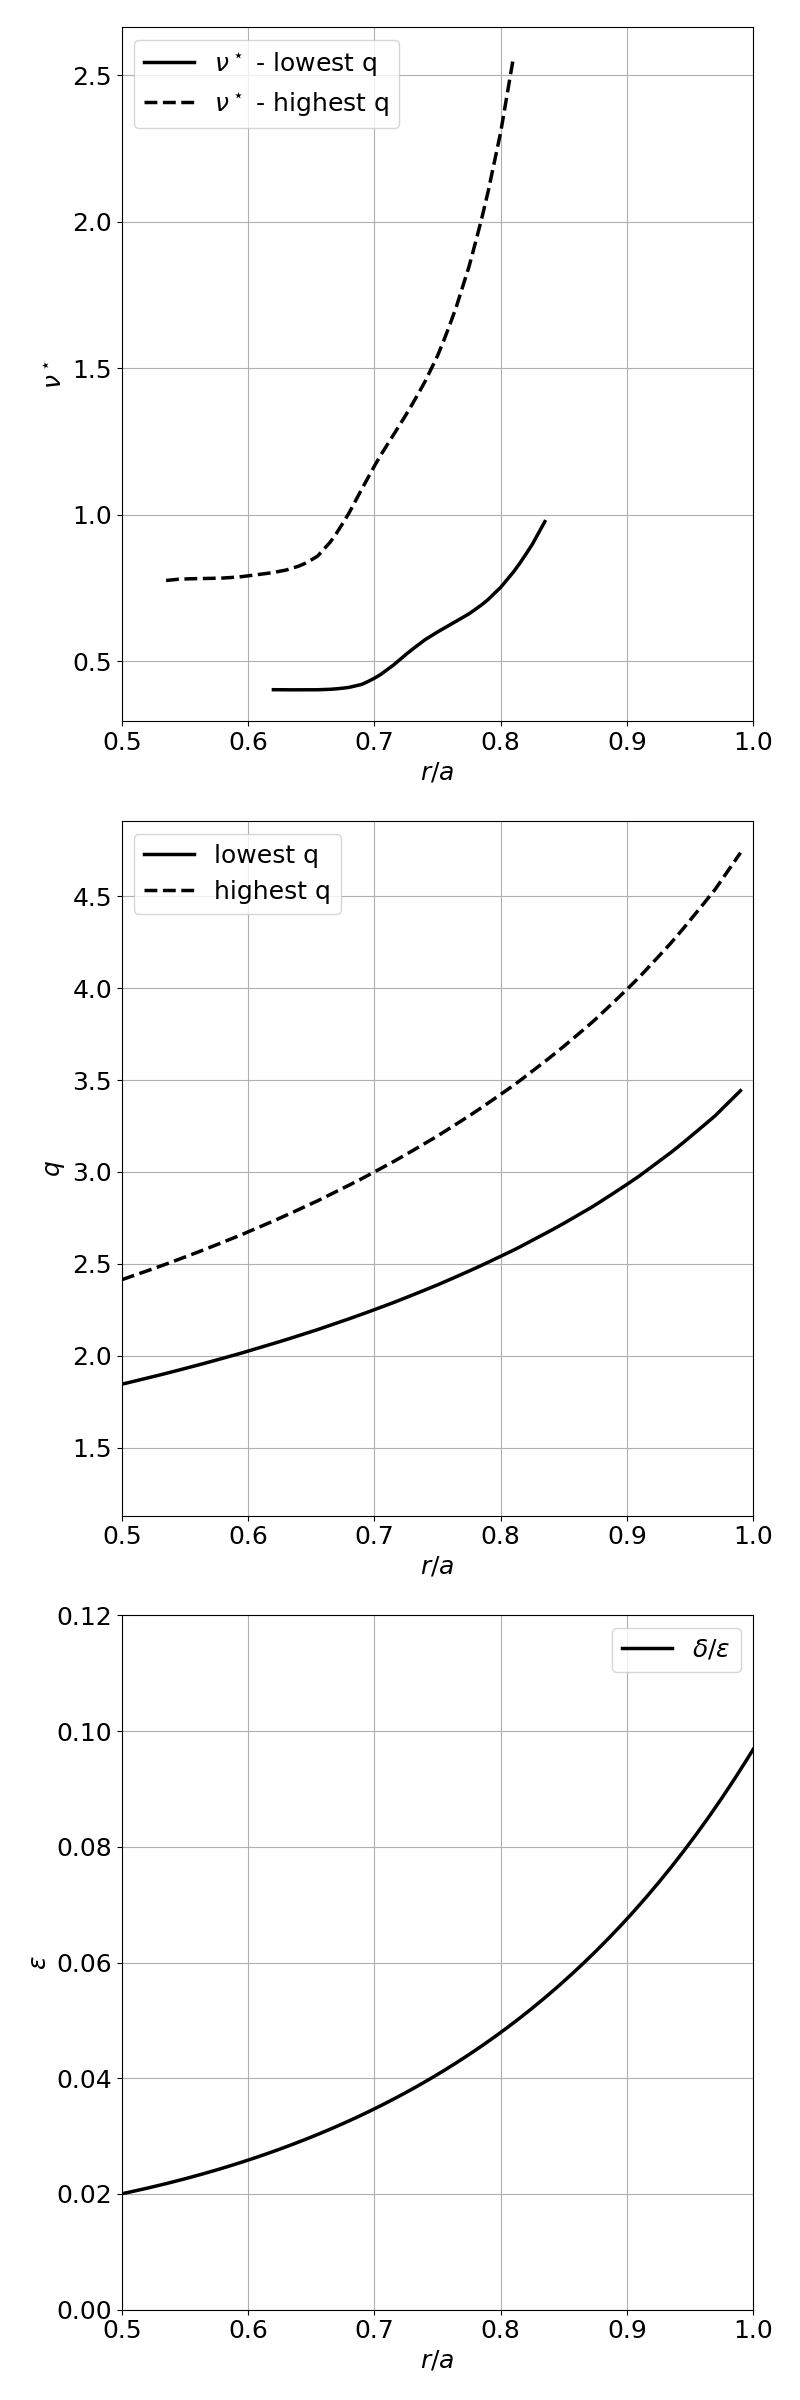

In [6]:
clear_output(wait=True)

fig = plt.figure(figsize=(8,24))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)
ax3 = fig.add_subplot(312)


ax1.plot(data_dic['rho'],data_dic['nustar_lowq'],'k-',label=r'$\nu^\star$ - lowest q')
ax1.plot(data_dic['rho'],data_dic['nustar_highq'],'k--',label=r'$\nu^\star$ - highest q')
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$\nu^\star}$')
ax1.legend(loc='best')

ax2.plot(data_dic['rho'],data_dic['delta']/data_dic['eps'],'k-',label=r'$\delta/\epsilon$')
# ax2.plot(data_dic['rho'],data_dic['delta'],'k-',label=r'$\delta$')
# ax2.plot(data_dic['rho'],data_dic['eps'],'k--',label=r'$\epsilon$')
ax2.set_xlabel(r'$r/a$')
ax2.set_ylabel(r'$\epsilon$')
ax2.legend(loc='best')
ax2.set_ylim(0,0.12)

ax3.plot(data_dic['rho'],data_dic['q_lowq'],'k-',label=r'lowest q')
ax3.plot(data_dic['rho'],data_dic['q_highq'],'k--',label=r'highest q')
ax3.set_xlabel(r'$r/a$')
ax3.set_ylabel(r'$q$')
ax3.legend(loc='best')

for axes in [ax1,ax2,ax3]:
    axes.set_xlim(0.5,1)

fig.tight_layout()

## <font color='coral'>**Calculating $k_E$ profile for experimental discharges** </font>

In [5]:
kE_ar1 = np.zeros(len(data_dic['rho']))
kE_ar2 = np.zeros(len(data_dic['rho']))

N=18

for il,(rho,nu1,nu2,eps,delta,q1,q2) in enumerate(zip(data_dic['rho'],data_dic['nustar_lowq'],data_dic['nustar_highq'],data_dic['eps'],data_dic['delta'],data_dic['q_lowq'],data_dic['q_highq'])):
    # print(nu1,nu2)
    if not(np.isnan(rho) or np.isnan(nu1) or np.isnan(nu2) or np.isnan(eps) or np.isnan(delta) or np.isnan(q1) or np.isnan(q2)):
        kE_ar1[il]=kT_kE_kP_new(delta/eps,nu1,N*q1)[1]
        kE_ar2[il]=kT_kE_kP_new(delta/eps,nu2,N*q2)[1]
    # print(il)
    # print(kE_ar1[il])
    # print(kE_ar2[il])

#print(kE_ar1)


C:\Users\RV273815\AppData\Local\Temp\ipykernel_13556\3259788412.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))
C:\Users\RV273815\AppData\Local\Temp\ipykernel_13556\3259788412.py:8: RuntimeWarning: invalid value encountered in double_scalars
  def min_ap(x,y): return x*y/(x+y)
C:\Users\RV273815\AppData\Local\Temp\ipykernel_13556\3259788412.py:45: RuntimeWarning: invalid value encountered in double_scalars
  K_tilde_u = (2/np.pi)**(1.5)*(1/nustar)*np.exp(-u) * u**(5/2)/nu_bar_u(u)* (\


## <font color='green'>**(TSVV Workshop)** </font> <font color='coral'>**Plotting $k_E$ profile for experimental discharges** </font>

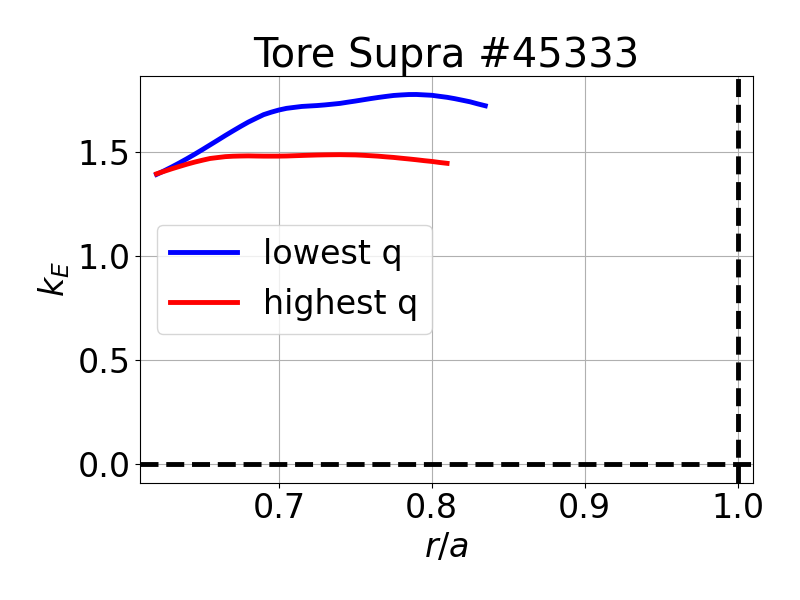

In [8]:
clear_output(wait=True)

plt.rcParams['lines.linewidth'] = 3.5
plt.rc('font',size=24)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(data_dic['rho'][kE_ar1>0],kE_ar1[kE_ar1>0],'b',label=r'lowest q')
ax1.plot(data_dic['rho'][kE_ar1>0],kE_ar2[kE_ar1>0],'r',label=r'highest q')
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$k_E$')
ax1.legend(loc='center left')
ax1.set_xlim(right=1.01)
ax1.set_title(r'Tore Supra #45333')

ax1.axhline(0.0,color='k',linestyle='--')
ax1.axvline(1.0,color='k',linestyle='--')

fig.tight_layout()

## Export rho and kE as .dat
np.savetxt('data_exp/kE_45333.dat',[data_dic['rho'],kE_ar1,kE_ar2])

# np.savetxt('data_exp/exp_profs_45333.dat')
# data_q = np.loadtxt('data_exp/exp_profs_q_45333.dat')

## <font color='green'>**(EPS Laure)** </font> <font color='coral'>**Chargement des données ** </font> <font color='red'> (with new data!) </font>

In [26]:
## New data
data_exp_new = np.loadtxt('data_exp/exp_profs_45333_Ti.dat')

param = ['rho', 'Te1', 'Te2', 'ne1', 'ne2', 'Ti1', 'Ti2', 'q1', 'q2', 'nustar1', 'nustar2']
data_dic_new  = {}
for ip,p in enumerate(param):
    data_dic_new[p] = data_exp_new[ip,:]

## Old data (useful for eps and delta)
data = np.loadtxt('data_exp/exp_profs_45333.dat')
data_q = np.loadtxt('data_exp/exp_profs_q_45333.dat')

data_exp_old = np.vstack((data,data_q))

param = ['rho','nustar_lowq','nustar_highq','eps','delta','q_lowq','q_highq']
data_dic_old  = {}
for ip,p in enumerate(param):
    data_dic_old[p] = data_exp_old[ip,:]

#estimate delta for new data
data_dic_new['delta'] = np.zeros(len(data_dic_new['rho']))
for irho,rho in enumerate(data_dic_new['rho']):
    data_dic_new['delta'][irho] = TS_ripple_FSavg(rho)

#interpolate eps of new data from eps of old data
data_dic_new['eps'] = np.interp(data_dic_new['rho'],data_dic_old['rho'],data_dic_old['eps'])

## <font color='green'>**(EPS Laure)** </font> <font color='coral'>**Plot profiles ** </font> <font color='red'> (with new data!) </font>

C:\Users\RV273815\AppData\Local\Temp\ipykernel_4448\808315624.py:21: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(data_dic_old['rho'],data_dic_old['delta']/data_dic_old['eps'],'k-',label=r'$\delta/\varepsilon$')
C:\Users\RV273815\AppData\Local\Temp\ipykernel_4448\808315624.py:22: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(data_dic_new['rho'],data_dic_new['delta']/data_dic_new['eps'],'k--',label=r'$\delta/\varepsilon$')


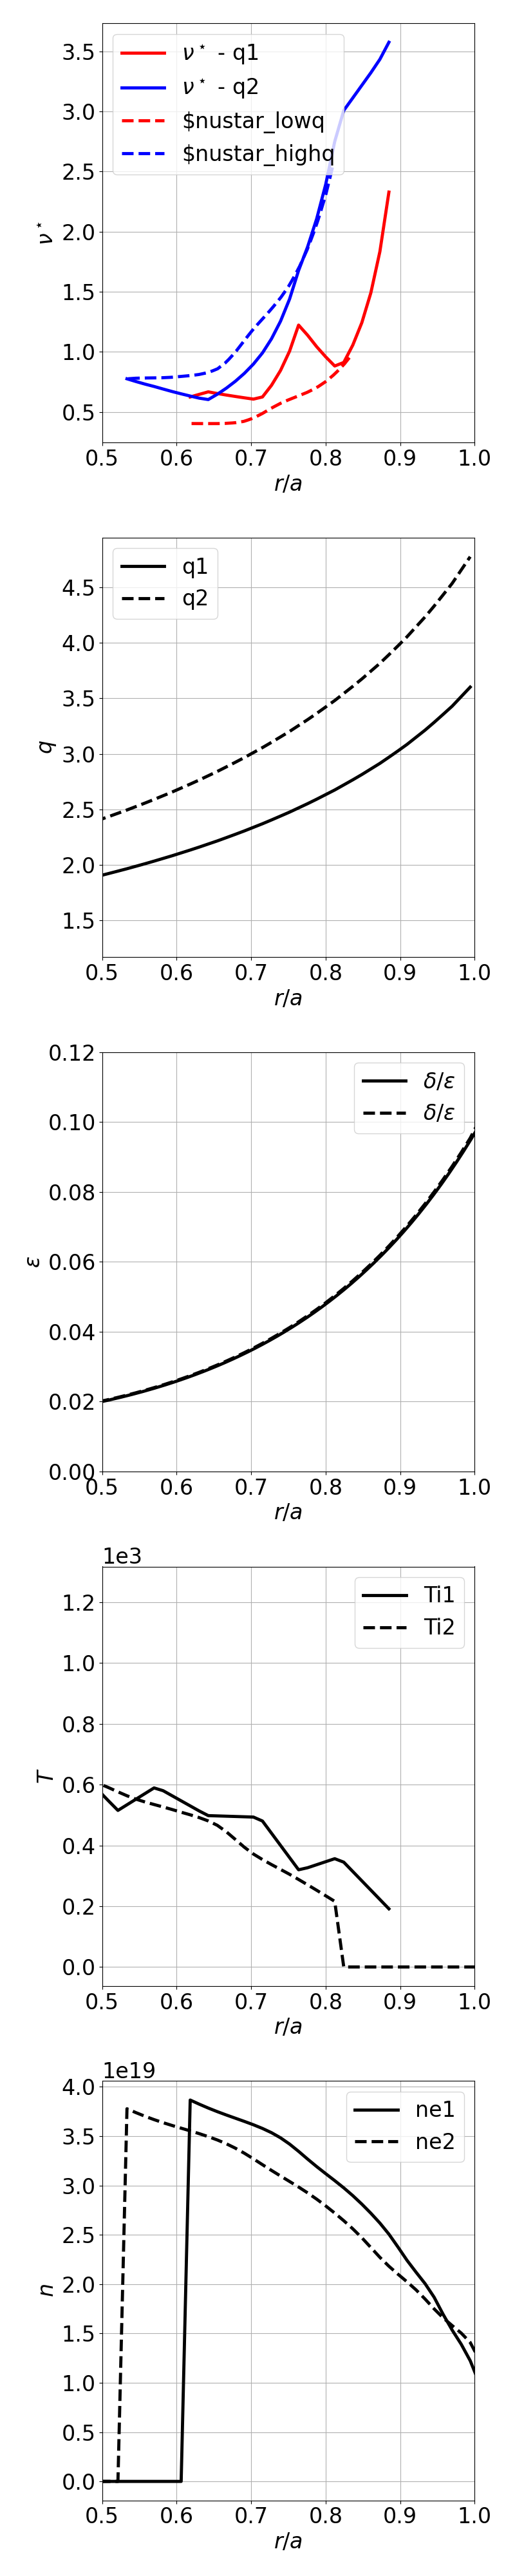

In [24]:
clear_output(wait=True)

fig = plt.figure(figsize=(8,40))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(513)
ax3 = fig.add_subplot(512)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)


ax1.plot(data_dic_new['rho'],data_dic_new['nustar1'],'r-',label=r'$\nu^\star$ - q1')
ax1.plot(data_dic_new['rho'],data_dic_new['nustar2'],'b-',label=r'$\nu^\star$ - q2')

ax1.plot(data_dic_old['rho'],data_dic_old['nustar_lowq'],'r--',label=r'$nustar_lowq')
ax1.plot(data_dic_old['rho'],data_dic_old['nustar_highq'],'b--',label=r'$nustar_highq')

ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$\nu^\star}$')
ax1.legend(loc='best')

ax2.plot(data_dic_old['rho'],data_dic_old['delta']/data_dic_old['eps'],'k-',label=r'$\delta/\varepsilon$')
ax2.plot(data_dic_new['rho'],data_dic_new['delta']/data_dic_new['eps'],'k--',label=r'$\delta/\varepsilon$')
# ax2.plot(data_dic['rho'],data_dic['delta'],'k-',label=r'$\delta$')
# ax2.plot(data_dic['rho'],data_dic['eps'],'k--',label=r'$\epsilon$')
ax2.set_xlabel(r'$r/a$')
ax2.set_ylabel(r'$\epsilon$')
ax2.legend(loc='best')
ax2.set_ylim(0,0.12)

ax3.plot(data_dic_new['rho'],data_dic_new['q1'],'k-',label=r'q1')
ax3.plot(data_dic_new['rho'],data_dic_new['q2'],'k--',label=r'q2')
ax3.set_xlabel(r'$r/a$')
ax3.set_ylabel(r'$q$')
ax3.legend(loc='best')

ax4.plot(data_dic_new['rho'],data_dic_new['Ti1'],'k-',label=r'Ti1')
ax4.plot(data_dic_new['rho'],data_dic_new['Ti2'],'k--',label=r'Ti2')
ax4.set_xlabel(r'$r/a$')
ax4.set_ylabel(r'$T$')
ax4.legend(loc='best')

ax5.plot(data_dic_new['rho'],data_dic_new['ne1'],'k-',label=r'ne1')
ax5.plot(data_dic_new['rho'],data_dic_new['ne2'],'k--',label=r'ne2')
ax5.set_xlabel(r'$r/a$')
ax5.set_ylabel(r'$n$')
ax5.legend(loc='best')

for axes in [ax1,ax2,ax3,ax4,ax5]:
    axes.set_xlim(0.5,1)

fig.tight_layout()

## <font color='green'>**(EPS Laure)** </font> <font color='coral'>Plotting $k_E$ profile for experimental discharges </font> <font color='red'> (with new data!) </font>

C:\Users\RV273815\AppData\Local\Temp\ipykernel_4448\3259788412.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))


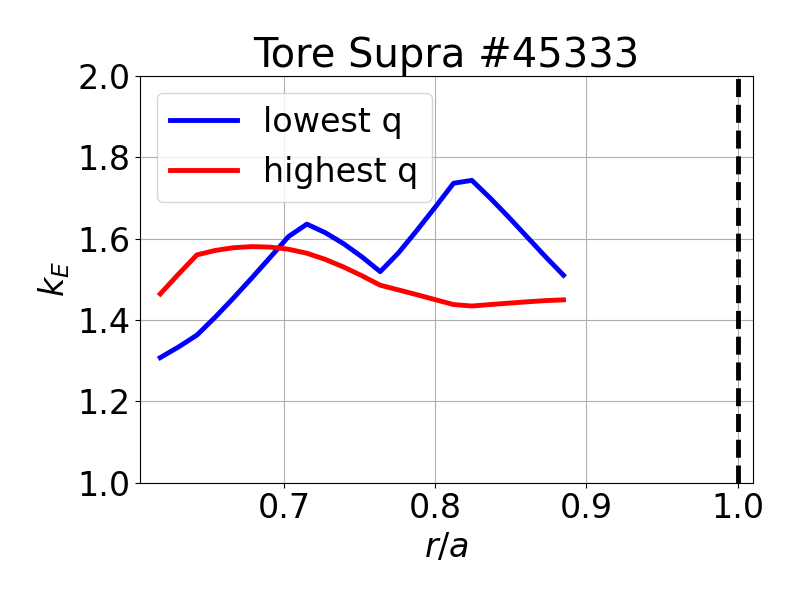

In [35]:
plt.rcParams['lines.linewidth'] = 3.5
plt.rc('font',size=24)

N=18

data_dic_new['kE1'] = np.zeros(len(data_dic_new['rho']))
data_dic_new['kE2'] = np.zeros(len(data_dic_new['rho']))

for il,(rho,nu1,nu2,eps,delta,q1,q2) in enumerate(zip(data_dic_new['rho'],data_dic_new['nustar1'],data_dic_new['nustar2'],data_dic_new['eps'],data_dic_new['delta'],data_dic_new['q1'],data_dic_new['q2'])):
    if not(np.isnan(rho) or np.isnan(nu1) or np.isnan(nu2) or np.isnan(eps) or np.isnan(delta) or np.isnan(q1) or np.isnan(q2)):
        data_dic_new['kE1'][il]=kT_kE_kP_new(delta/eps,nu1,N*q1)[1]
        data_dic_new['kE2'][il]=kT_kE_kP_new(delta/eps,nu2,N*q2)[1]

kE_ar1 = data_dic_new['kE1']
kE_ar2 = data_dic_new['kE2']

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(data_dic['rho'][kE_ar1>0],kE_ar1[kE_ar1>0],'b',label=r'lowest q')
ax1.plot(data_dic['rho'][kE_ar1>0],kE_ar2[kE_ar1>0],'r',label=r'highest q')
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$k_E$')
ax1.legend()
ax1.set_xlim(right=1.01)
ax1.set_title(r'Tore Supra #45333')

ax1.axhline(0.0,color='k',linestyle='--')
ax1.axvline(1.0,color='k',linestyle='--')

ax1.set_ylim(bottom=1, top=2)

fig.tight_layout()

## Export rho and kE as .dat
np.savetxt('data_exp/kE_45333.dat',[data_dic['rho'],kE_ar1,kE_ar2])

# np.savetxt('data_exp/exp_profs_45333.dat')
# data_q = np.loadtxt('data_exp/exp_profs_q_45333.dat')


## <font color='green'>**(EPS Laure)** </font> <font color='coral'>**Reconstructing $E_r$ ** </font> <font color='red'> (with new data!) </font>

$E_r = T_{kelvin} \left( k_E \frac{d ln T_{ev}}{dr} - k_E \frac{d ln (n_{m^3/s})}{dr} \right)$

C:\Users\RV273815\AppData\Local\Temp\ipykernel_4448\3283765593.py:4: RuntimeWarning: divide by zero encountered in log
  data_dic_new['Ti2_J'] = np.log(data_dic_new['Ti2']) * 1.6e-19
C:\Users\RV273815\AppData\Local\Temp\ipykernel_4448\3283765593.py:7: RuntimeWarning: divide by zero encountered in log
  data_dic_new['Ti2_K'] = np.log(data_dic_new['Ti2']) * (1.6/1.38)*1e4
C:\Users\RV273815\AppData\Local\Temp\ipykernel_4448\3283765593.py:13: RuntimeWarning: invalid value encountered in log
  data_dic_new['drlnT2'] = np.gradient(np.log(data_dic_new['Ti2_J']),data_dic_new['rho']*a)
C:\Users\RV273815\AppData\Local\Temp\ipykernel_4448\3283765593.py:18: RuntimeWarning: divide by zero encountered in log
  data_dic_new['drlnn1'] = np.gradient(np.log(data_dic_new['ne1']),data_dic_new['rho']*a)
c:\Users\RV273815\Anaconda3\envs\post_treating\lib\site-packages\numpy\lib\function_base.py:1247: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tu

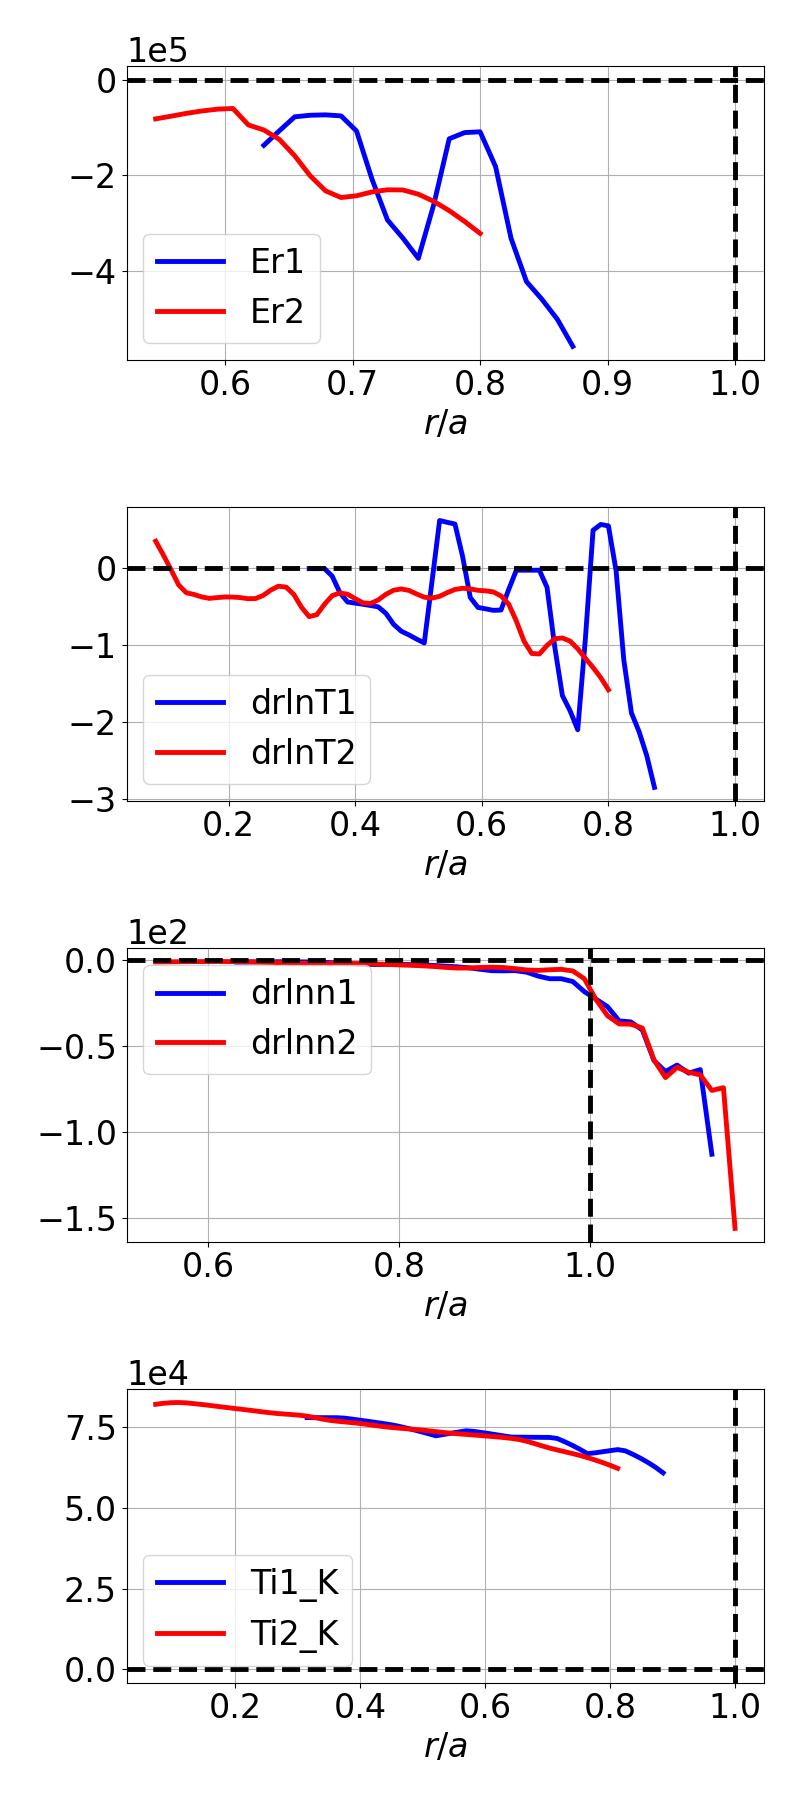

In [45]:
a = 2.3946/3.2 #m

data_dic_new['Ti1_J'] = np.log(data_dic_new['Ti1']) * 1.6e-19
data_dic_new['Ti2_J'] = np.log(data_dic_new['Ti2']) * 1.6e-19

data_dic_new['Ti1_K'] = np.log(data_dic_new['Ti1']) * (1.6/1.38)*1e4
data_dic_new['Ti2_K'] = np.log(data_dic_new['Ti2']) * (1.6/1.38)*1e4

# data_dic_new['drlnT1'] = np.gradient(data_dic_new['Ti1_J'],data_dic_new['rho']*a)/data_dic_new['Ti1_J']
# data_dic_new['drlnT2'] = np.gradient(data_dic_new['Ti2_J'],data_dic_new['rho']*a)/data_dic_new['Ti2_J']

data_dic_new['drlnT1'] = np.gradient(np.log(data_dic_new['Ti1_J']),data_dic_new['rho']*a)
data_dic_new['drlnT2'] = np.gradient(np.log(data_dic_new['Ti2_J']),data_dic_new['rho']*a)

# data_dic_new['drlnn1'] = np.gradient(data_dic_new['ne1'],data_dic_new['rho']*a)/data_dic_new['ne1']
# data_dic_new['drlnn2'] = np.gradient(data_dic_new['ne2'],data_dic_new['rho']*a)/data_dic_new['ne2']

data_dic_new['drlnn1'] = np.gradient(np.log(data_dic_new['ne1']),data_dic_new['rho']*a)
data_dic_new['drlnn2'] = np.gradient(np.log(data_dic_new['ne2']),data_dic_new['rho']*a)

data_dic_new['Er1'] = data_dic_new['Ti1_K'] * ( data_dic_new['kE1'] * data_dic_new['drlnT1'] + data_dic_new['drlnn1'] )
data_dic_new['Er2'] = data_dic_new['Ti2_K'] * ( data_dic_new['kE2'] * data_dic_new['drlnT2'] + data_dic_new['drlnn2'] )

fig = plt.figure(figsize=(8,18))
ax1 = fig.add_subplot(411)
ax1.plot(data_dic_new['rho'],data_dic_new['Er1'],'b',label=r'Er1')
ax1.plot(data_dic_new['rho'],data_dic_new['Er2'],'r',label=r'Er2')
ax1.set_xlabel(r'$r/a$')

ax2 = fig.add_subplot(412)
ax2.plot(data_dic_new['rho'],data_dic_new['drlnT1'],'b',label=r'drlnT1')
ax2.plot(data_dic_new['rho'],data_dic_new['drlnT2'],'r',label=r'drlnT2')
ax2.set_xlabel(r'$r/a$')

ax3 = fig.add_subplot(413)
ax3.plot(data_dic_new['rho'],data_dic_new['drlnn1'],'b',label=r'drlnn1')
ax3.plot(data_dic_new['rho'],data_dic_new['drlnn2'],'r',label=r'drlnn2')
ax3.set_xlabel(r'$r/a$')

ax4 = fig.add_subplot(414)
ax4.plot(data_dic_new['rho'],data_dic_new['Ti1_K'],'b',label=r'Ti1_K')
ax4.plot(data_dic_new['rho'],data_dic_new['Ti2_K'],'r',label=r'Ti2_K')
ax4.set_xlabel(r'$r/a$')

for ax in [ax1,ax2,ax3,ax4]:
    ax.legend()
    ax.axvline(x=1,color='k',linestyle='--')
    ax.axhline(y=0,color='k',linestyle='--')

fig.tight_layout()